# attempting to find fields most correlated with high gross

In [19]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# example: load your dataset
df = pd.read_csv('../Data/processed/movies_model.csv')
df


,name,rating,genre,year,released,score,votes,director,writer,star,...,runtime,release_date,decade,InflationMultiplier,adjusted_gross,adjusted_budget,gross_discrete,budget_discrete,company_grouped,is_domestic
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,...,146.0,1980-06-13,1980s,3.89,1.828252e+08,73910000.0,183.0,74.0,Warner Brothers,True
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,...,104.0,1980-07-02,1980s,3.89,2.289386e+08,17505000.0,229.0,18.0,Columbia Pictures,True
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,...,124.0,1980-06-20,1980s,3.89,2.094279e+09,70020000.0,2094.0,70.0,Luscasfilm,True
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,...,88.0,1980-07-02,1980s,3.89,3.246343e+08,13615000.0,325.0,14.0,Paramount Pictures,True
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,...,98.0,1980-07-25,1980s,3.89,1.550023e+08,23340000.0,155.0,23.0,Orion Pictures,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6598,The Eight Hundred,Not Rated,Action,2020,"August 28, 2020 (United States)",6.8,3700.0,Hu Guan,Hu Guan,Zhi-zhong Huang,...,149.0,2020-08-28,2020s,1.24,5.721627e+08,99200000.0,572.0,99.0,Beijing Diqi Yinxiang Entertainment,True
6599,Legend of Deification,TV-PG,Animation,2020,"October 1, 2020 (United States)",6.6,1300.0,Teng Cheng,NaN,Guangtao Jiang,...,110.0,2020-10-01,2020s,1.24,2.984223e+08,NaN,298.0,NaN,Beijing Enlight Pictures,True
6600,Tulsa,PG-13,Comedy,2020,"June 3, 2020 (United States)",5.0,294.0,Scott Pryor,Scott Pryor,Scott Pryor,...,120.0,2020-06-03,2020s,1.24,5.125887e+05,NaN,1.0,NaN,Pryor Entertainment,True
6601,Leap,NaN,Drama,2020,"September 25, 2020 (United States)",6.7,903.0,Peter Ho-Sun Chan,Ji Zhang,Gong Li,...,135.0,2020-09-25,2020s,1.24,3.201541e+07,NaN,32.0,NaN,NaN,True


Numeric fields: ['score', 'runtime', 'gross_discrete', 'budget_discrete']
Categorical fields: ['rating', 'genre', 'director', 'writer', 'star', 'company_grouped']

Correlation of each feature to gross_discrete:
           feature  correlation           method
1            genre    -0.236585  encoded_pearson
2            score     0.233664          pearson
8  company_grouped     0.166340  encoded_pearson
0           rating    -0.151288  encoded_pearson
4           writer    -0.017667  encoded_pearson
5             star     0.008980  encoded_pearson
3         director    -0.005168  encoded_pearson
6          runtime          NaN          pearson
7  budget_discrete          NaN          pearson


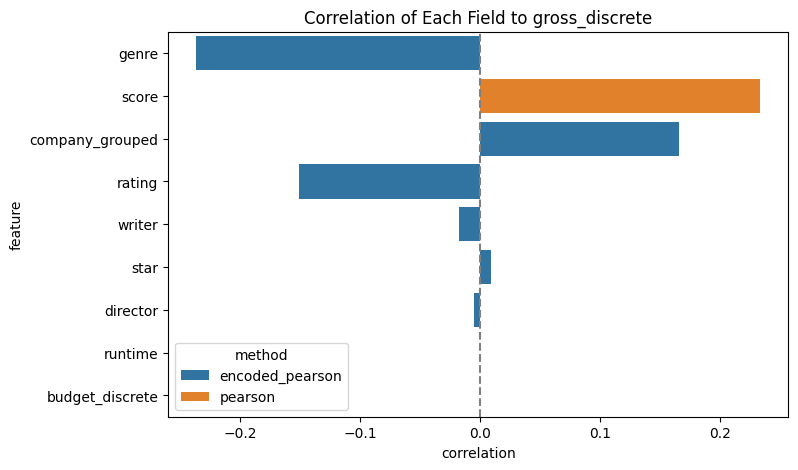

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, pointbiserialr
from sklearn.preprocessing import LabelEncoder

# -------------------------------
# 1. Load and reduce to in-scope fields
# -------------------------------
in_scope = [
    'rating', 'genre', 'score', 'director', 'writer', 
    'star', 'runtime', 'budget_discrete', 
    'company_grouped', 'gross_discrete'
]

df = pd.read_csv('../Data/processed/movies_model.csv', usecols=in_scope).dropna(subset=['gross_discrete'])

# -------------------------------
# 2. Detect numeric vs categorical
# -------------------------------
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = [col for col in df.columns if col not in numeric_cols + ['gross_discrete']]

print("Numeric fields:", numeric_cols)
print("Categorical fields:", categorical_cols)

# -------------------------------
# 3. Compute correlation of each feature to gross_discrete
# -------------------------------
corr_results = []

for col in df.columns:
    if col == 'gross_discrete':
        continue

    # If numeric → use Pearson correlation
    if col in numeric_cols:
        corr, _ = pearsonr(df[col], df['gross_discrete'])
        corr_results.append((col, corr, 'pearson'))
    
    # If categorical → encode and use Pearson on numeric codes
    else:
        encoder = LabelEncoder()
        encoded = encoder.fit_transform(df[col].astype(str))
        corr, _ = pearsonr(encoded, df['gross_discrete'])
        corr_results.append((col, corr, 'encoded_pearson'))

# Convert to DataFrame for easy sorting/plotting
corr_df = pd.DataFrame(corr_results, columns=['feature', 'correlation', 'method'])
corr_df = corr_df.sort_values(by='correlation', key=abs, ascending=False)

print("\nCorrelation of each feature to gross_discrete:")
print(corr_df)

# -------------------------------
# 4. Visualize
# -------------------------------
plt.figure(figsize=(8,5))
sns.barplot(data=corr_df, x='correlation', y='feature', hue='method', dodge=False)
plt.title('Correlation of Each Field to gross_discrete')
plt.axvline(0, color='gray', linestyle='--')
plt.show()


In [36]:
from itertools import combinations
from sklearn.preprocessing import LabelEncoder

# Encode all categoricals for numerical use
df_encoded = df.copy()
for col in categorical_cols:
    df_encoded[col] = LabelEncoder().fit_transform(df[col].astype(str))

combo_results = []

# iterate through all unique pairs
for col1, col2 in combinations([c for c in df_encoded.columns if c != 'gross_discrete'], 2):
    # combine columns — simple additive combination (you could also use interactions)
    combined = df_encoded[col1] + df_encoded[col2]
    corr, _ = pearsonr(combined, df_encoded['gross_discrete'])
    combo_results.append((col1, col2, corr))

combo_df = pd.DataFrame(combo_results, columns=['feature_1', 'feature_2', 'correlation'])
combo_df = combo_df.sort_values(by='correlation', key=abs, ascending=False)

print("\nTop 10 two-field correlations to gross_discrete:")
print(combo_df.head(10))



Top 10 two-field correlations to gross_discrete:
   feature_1        feature_2  correlation
0     rating            genre    -0.263503
20     score  company_grouped     0.166756
7     rating  company_grouped     0.166049
14     genre  company_grouped     0.165227
8      genre            score    -0.140308
32      star  company_grouped     0.110163
25  director  company_grouped     0.094394
29    writer  company_grouped     0.055402
1     rating            score     0.033767
10     genre           writer    -0.018220



Top correlated feature pairs to gross_discrete:
   feature_1        feature_2  correlation  abs_corr
0     rating            genre    -0.263503  0.263503
20     score  company_grouped     0.166756  0.166756
7     rating  company_grouped     0.166049  0.166049
14     genre  company_grouped     0.165227  0.165227
8      genre            score    -0.140308  0.140308
32      star  company_grouped     0.110163  0.110163
25  director  company_grouped     0.094394  0.094394
29    writer  company_grouped     0.055402  0.055402
1     rating            score     0.033767  0.033767
10     genre           writer    -0.018220  0.018220


Text(0.5, 0, 'Correlation')

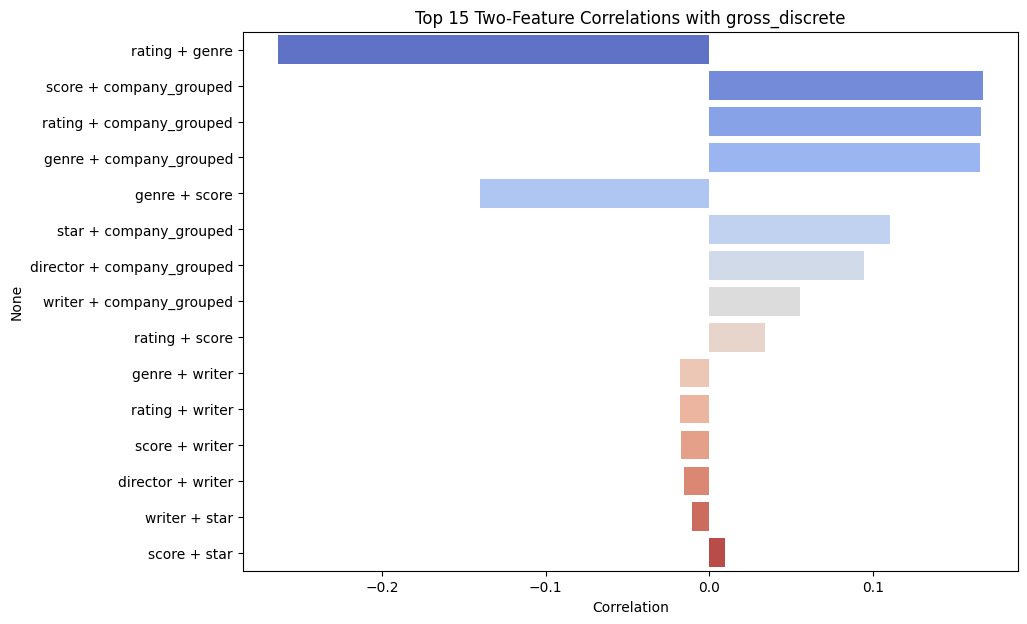

In [37]:
from itertools import combinations
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr

# --------------------------------
# Encode categoricals numerically
# --------------------------------
df_encoded = df.copy()
for col in categorical_cols:
    df_encoded[col] = LabelEncoder().fit_transform(df[col].astype(str))

# --------------------------------
# Compute correlation for every pair of features vs gross_discrete
# --------------------------------
combo_results = []

for col1, col2 in combinations([c for c in df_encoded.columns if c != 'gross_discrete'], 2):
    combined = df_encoded[col1] + df_encoded[col2]  # simple combination
    corr, _ = pearsonr(combined, df_encoded['gross_discrete'])
    combo_results.append((col1, col2, corr))

combo_df = pd.DataFrame(combo_results, columns=['feature_1', 'feature_2', 'correlation'])
combo_df['abs_corr'] = combo_df['correlation'].abs()
combo_df = combo_df.sort_values(by='abs_corr', ascending=False)

print("\nTop correlated feature pairs to gross_discrete:")
print(combo_df.head(10))

# --------------------------------
# 1️⃣ Seaborn bar chart (Top 15 pairs)
# --------------------------------
plt.figure(figsize=(10, 7))
sns.barplot(
    data=combo_df.head(15),
    x='correlation',
    y=combo_df.head(15).apply(lambda row: f"{row['feature_1']} + {row['feature_2']}", axis=1),
    palette='coolwarm'
)
plt.title('Top 15 Two-Feature Correlations with gross_discrete')
plt.xlabel('Correlation')



R² of (budget_discrete + feature) vs gross_discrete:
           feature        r2
2            score  0.492666
6          runtime  0.452446
0           rating  0.450784
7  company_grouped  0.450704
5             star  0.449032
3         director  0.449030
1            genre  0.449008
4           writer  0.448749


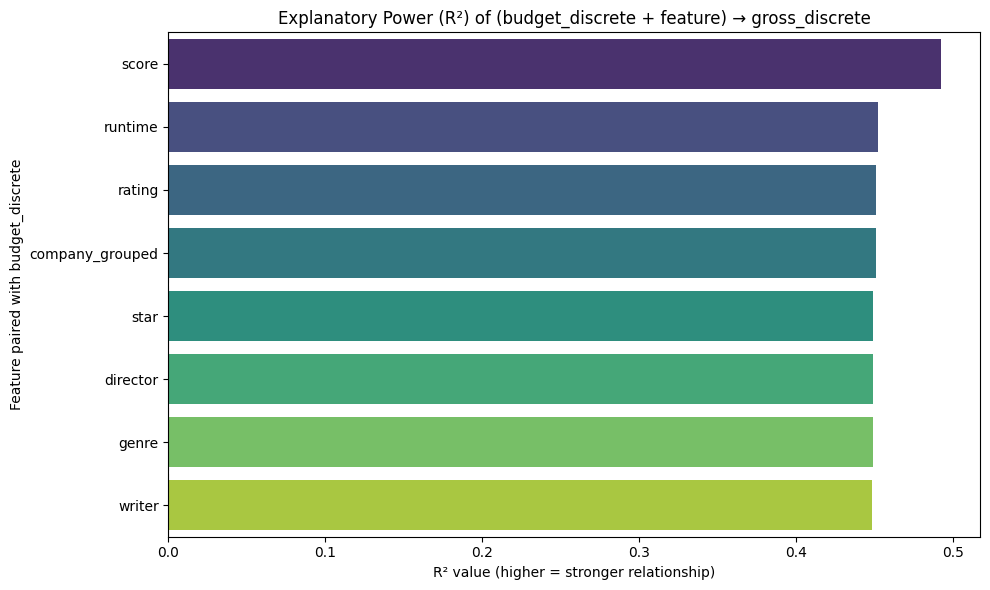

In [39]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr, pointbiserialr

# -------------------------------
# 1. Load and reduce to in-scope fields
# -------------------------------
in_scope = [
    'rating', 'genre', 'score', 'director', 'writer', 
    'star', 'runtime', 'budget_discrete', 
    'company_grouped', 'gross_discrete'
]

df = pd.read_csv('../Data/processed/movies_model.csv', usecols=in_scope).dropna(subset=['gross_discrete'])


target = 'gross_discrete'
base_feature = 'budget_discrete'

# Identify categorical columns
categorical_cols = df.select_dtypes(include='object').columns.tolist()

# Encode categoricals numerically
df_encoded = df.copy()
for col in categorical_cols:
    df_encoded[col] = LabelEncoder().fit_transform(df[col].astype(str))

# --- Drop rows missing the target ---
df_encoded = df_encoded.dropna(subset=[target])

r2_results = []

for col in df_encoded.columns:
    if col in [target, base_feature]:
        continue

    # Select subset for these columns
    X = df_encoded[[base_feature, col]]
    y = df_encoded[target]

    # Handle missing values safely (drop only where needed)
    temp = pd.concat([X, y], axis=1).dropna()
    X_clean = temp[[base_feature, col]]
    y_clean = temp[target]

    if len(X_clean) < 10:
        # skip small sample sizes to avoid unstable correlations
        continue

    # Fit regression model
    model = LinearRegression().fit(X_clean, y_clean)
    y_pred = model.predict(X_clean)
    r2 = r2_score(y_clean, y_pred)

    r2_results.append((col, r2))

# Convert results to DataFrame
r2_df = pd.DataFrame(r2_results, columns=['feature', 'r2']).sort_values(by='r2', ascending=False)

print("\nR² of (budget_discrete + feature) vs gross_discrete:")
print(r2_df)

# Visualization
plt.figure(figsize=(10,6))
sns.barplot(data=r2_df, x='r2', y='feature', palette='viridis')
plt.title("Explanatory Power (R²) of (budget_discrete + feature) → gross_discrete")
plt.xlabel("R² value (higher = stronger relationship)")
plt.ylabel("Feature paired with budget_discrete")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

